<div style="background-color: #10002b; color: #e0aaff; padding: 20px;">
    <div style="background-color: #240046; padding: 20px; margin-top: 20px;">
        <h1 style="color: #e0aaff;">Binary Classification with a Bank Churn Dataset</h1>
        <h2 style="color: #e0aaff;">Playground Series - Season 4, Episode 1</h2>
    </div>
    <div style="background-color: #3c096c; padding: 15px; margin-top: 20px;">
        <h2 style="color: #e0aaff;">Overview</h2>
        <p>Welcome to the 2024 Kaggle Playground Series! Happy New Year! This is the 1st episode of Season 4.</p>
    </div>
    <div style="background-color: #5a189a; padding: 15px; margin-top: 20px;">
        <h2 style="color: #e0aaff;">Your Goal</h2>
        <p>For this Episode of the Series, our task is to predict whether a customer continues with their account or closes it (e.g., churns)</p>
    </div>
    <div style="background-color: #7b2cbf; padding: 15px; margin-top: 20px;">
        <h2 style="color: #e0aaff;">Ensemble Model Technique</h2>
        <p>It is my first kaggle competition, so i wanted to leave a good impression and use my knowledge & skills to the max. 
            Hence, I used Ensemble learning.</p>
    </div>
</div>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import warnings
from tqdm.notebook import tqdm
import re
from functools import partial
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pximport 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score


In [4]:
# Reading Data Files
train = pd.read_csv('./playground-series-s4e1/train.csv')
test = pd.read_csv('./playground-series-s4e1/test.csv')
submission = pd.read_csv('./playground-series-s4e1/sample_submission.csv')




In [5]:
# Data Preprocessing
def preprocess_data(data):
    data['Age'] = data['Age'].astype(int)
    data['NumOfProducts'] = data['NumOfProducts'].astype(int)
    data['HasCrCard'] = data['HasCrCard'].astype(int)
    data['IsActiveMember'] = data['IsActiveMember'].astype(int)
    return data

In [6]:
train = preprocess_data(train)
test = preprocess_data(test)

In [7]:
print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (165034, 14)
The dimension of the test dataset is: (110023, 13)


In [8]:
def Null_values(data):
    return data.isnull().sum()

In [9]:
print("Null count in Train\n")
Null_values(train)


Null count in Train



id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
print("Null count in Test\n")
Null_values(test)


Null count in Test



id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

# There are no missing values in Train or Test dataset.

In [11]:
def Value_count(data):
    """
    Get value counts or unique values for all categorical columns in a DataFrame.

    Parameters:
    - data: DataFrame
        The input data.

    Returns:
    - list of dicts
        A list where each element is a dictionary containing information
        about a categorical column, including column name, type, and either
        value counts or unique values.
    """
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    result_list = []

    for col in categorical_cols:
        unique_values = data[col].unique()

        if len(unique_values) == data[col].nunique():
            result_list.append({
                "Column": col,
                "Type": "Unique",
                "Values": unique_values.tolist()
            })
        else:
            result_list.append({
                "Column": col,
                "Type": "Value Counts",
                "Counts": data[col].value_counts().to_dict()
            })

    return result_list

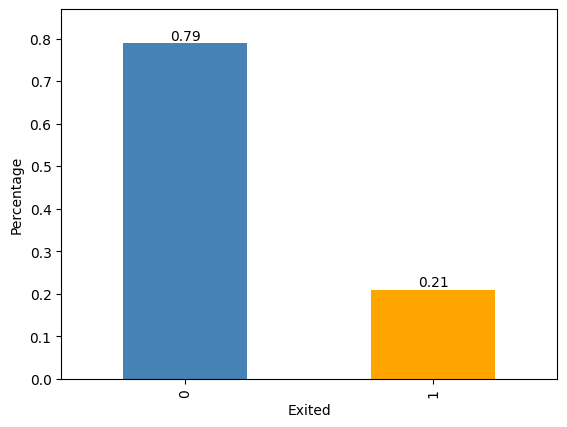

In [12]:
# Data Exploration
ax = round(train['Exited'].value_counts(normalize=True), 2).plot(kind='bar', color=['steelblue', 'orange'])
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.ylabel('Percentage')
plt.show()

We can see that the Churn Bank dataset is imbalanced. Explore the <code> exited </code> with other variables to obtain relationship of other variables with the 'Exited' 

# Data Exploration 

In [13]:
def plot_relationship(df, variable):
    """
    Create visualizations to explore the relationship between 'exited' and another variable.

    Parameters:
    - df: DataFrame
        The input data.
    - variable: str
        The name of the variable to be visualized.

    Returns:
    - None (but displays the plots)
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if df[variable].dtype == 'O':  # Categorical variable
        sns.countplot(ax=axes[0], data=df, x=variable, hue='Exited')
        axes[0].set_title(f'Count of {variable} by Exited')
        axes[0].set_xlabel(variable)
        axes[0].set_ylabel('Count')

        sns.barplot(ax=axes[1], data=df, x=variable, y='Exited', ci=None)
        axes[1].set_title(f'Exit Rate by {variable}')
        axes[1].set_xlabel(variable)
        axes[1].set_ylabel('Exit Rate')

    elif df[variable].dtype in ['int64', 'float64','int32']:  # Numerical variable
        sns.kdeplot(ax=axes[0], data=df, x=variable, hue='Exited', fill=True)
        axes[0].set_title(f'Kernel Density Estimate (KDE) of {variable} by Exited')
        axes[0].set_xlabel(variable)
        axes[0].set_ylabel('Density')

        sns.boxplot(ax=axes[1], data=df, x='Exited', y=variable, hue='Exited')
        axes[1].set_title(f'Distribution of {variable} by Exited')
        axes[1].set_xlabel('Exited')
        axes[1].set_ylabel(variable)

    else:
        print("Unsupported variable type. Please provide a categorical or numerical variable.")

    plt.tight_layout()
    plt.show()

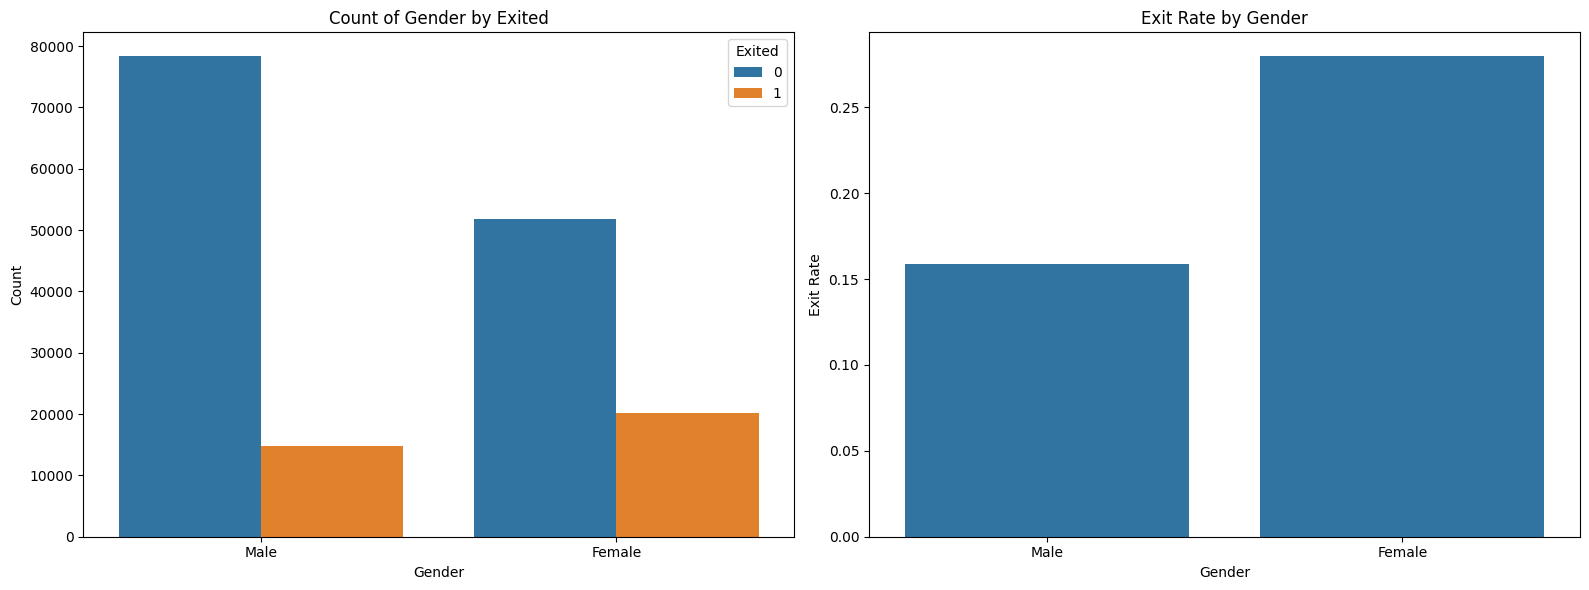

In [14]:
plot_relationship(train, 'Gender')

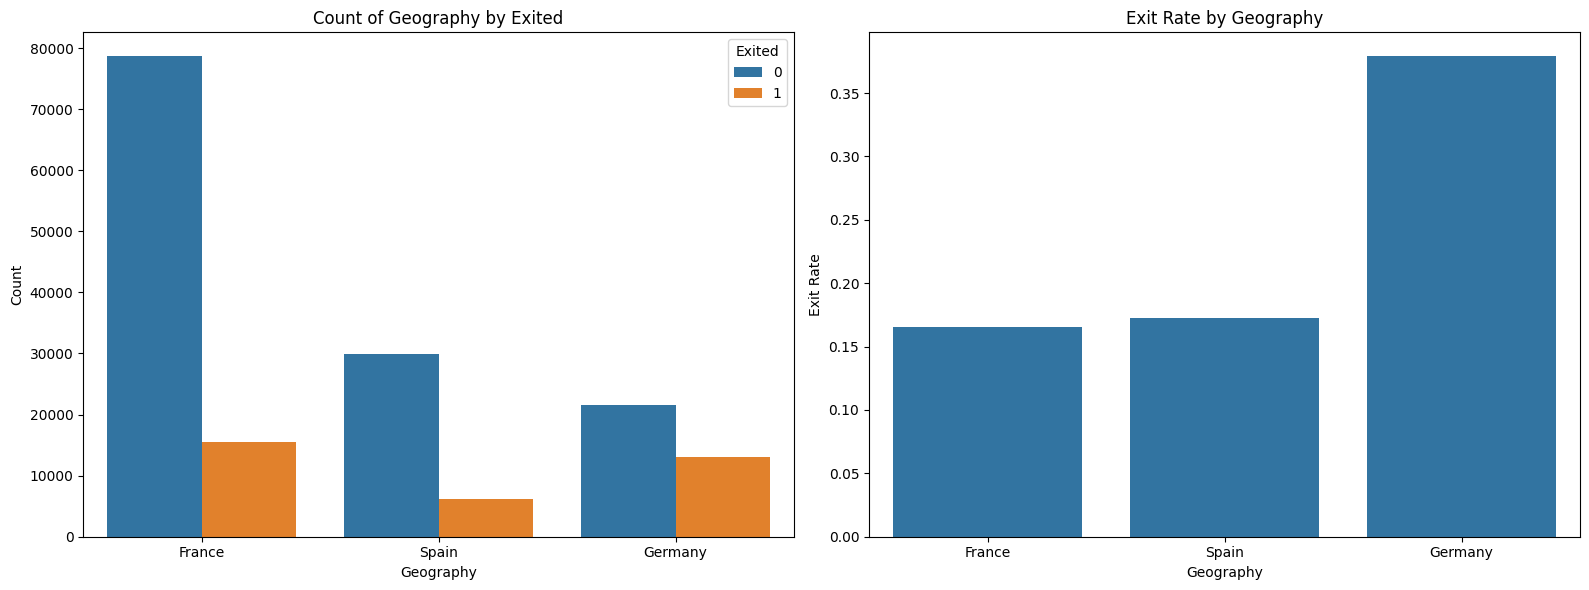

In [15]:
plot_relationship(train, 'Geography')

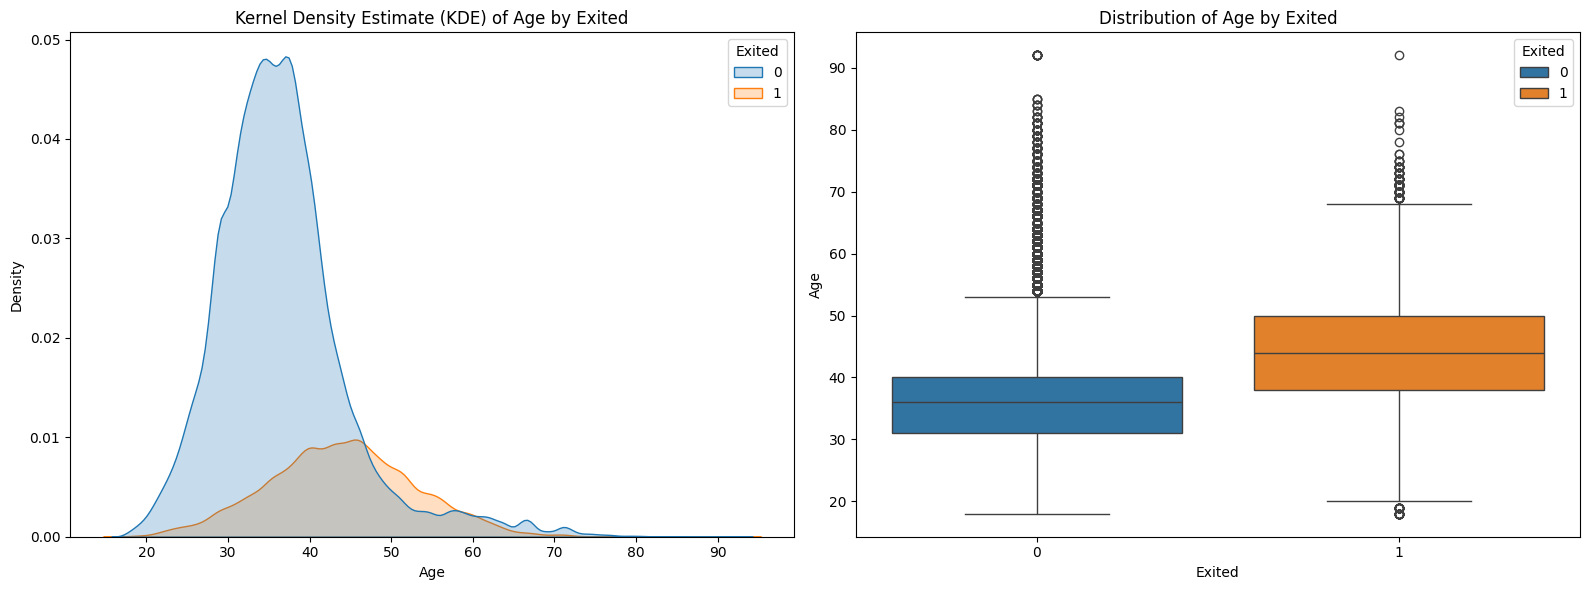

In [16]:
plot_relationship(train,'Age')

1. **Common Trends in Both Groups:**
In our analysis of customers who stayed (Exited=0) and those who left (Exited=1), we noticed a consistent pattern in a particular aspect we investigated. Both groups seem to share a common trend, suggesting similarities in their behavior.

2. **Age and Exit Status:**
Examining the age distribution, we found an interesting connection. The overall distribution leans towards the older side for customers who exited (Exited=1). On average, customers who left tend to be older. This insight sheds light on a potential correlation between age and the likelihood of customers deciding to leave.


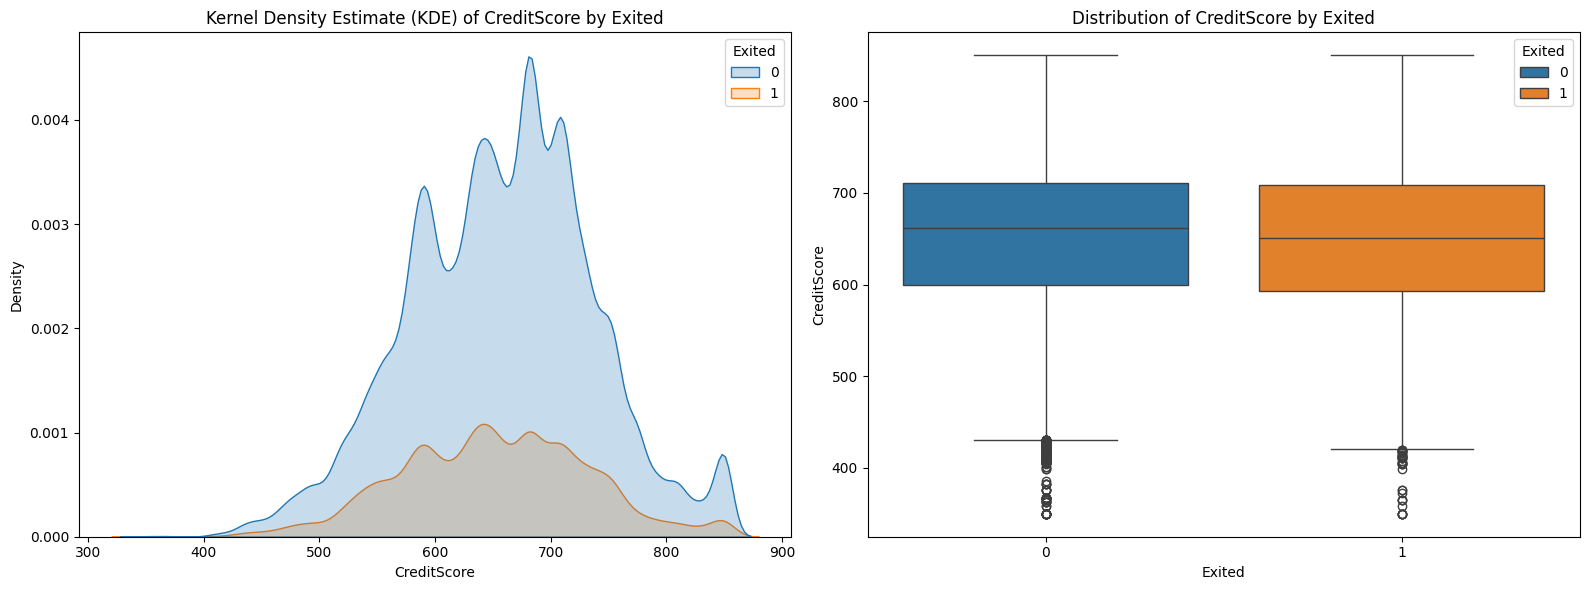

In [17]:
plot_relationship(train,'CreditScore')

1. **Both Groups Look Alike:**
When comparing customers who stayed (didn't exit) with those who left, we observed a similar pattern in a specific variable we examined (let's call it Thing X). It's as if both groups follow the same trend or behave in a comparable way.

2. **Patterns Lean to the Left:**
Upon examining the overall shape of how Thing X is distributed, we noticed a slight leftward tilt. Picture a graph – most of the points gather on the right side, and the graph gradually tapers off towards the left. This suggests that there are some values on the lower side, influencing the overall pattern to lean to the left.


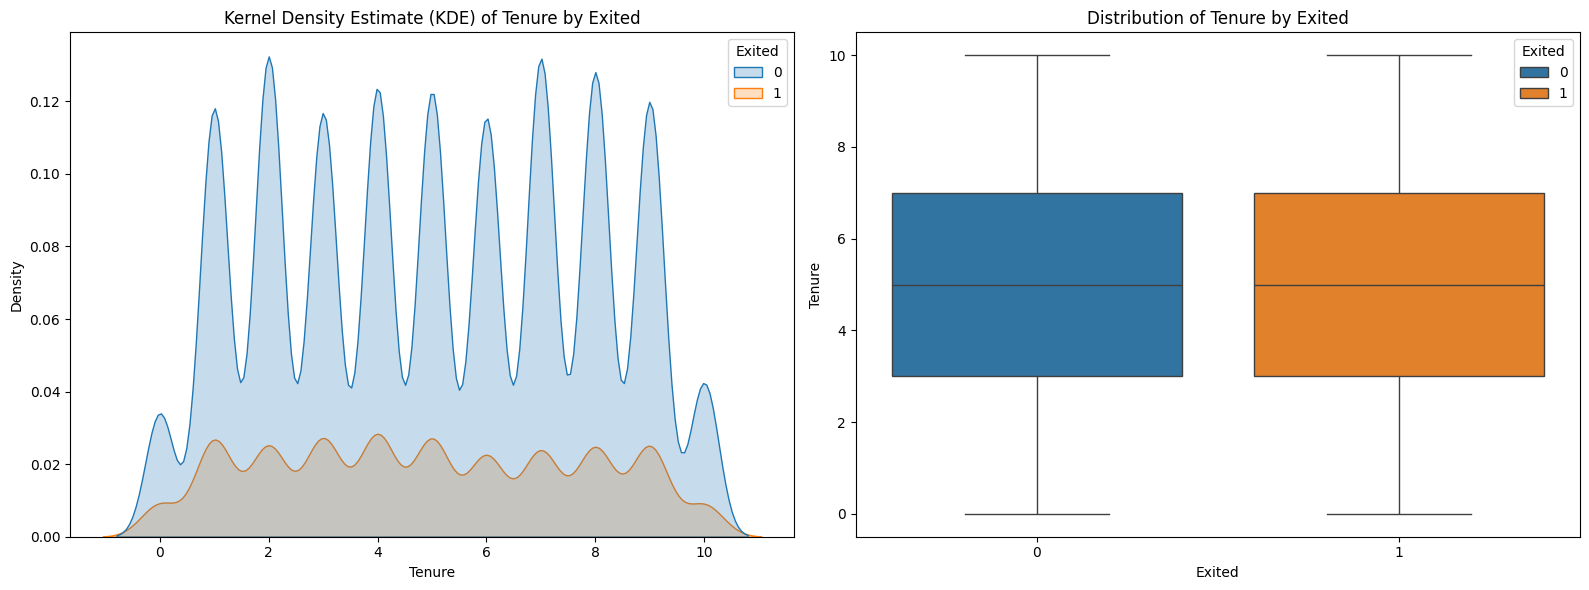

In [18]:
plot_relationship(train,'Tenure')

1. **Consistent Patterns Across Groups:**
   The distributions of the groups we explored appear to be quite similar. It's as if they follow the same overall trend or have comparable characteristics, suggesting consistency between the groups.

2. **Multi-Modal Distribution of Tenure:**
   Focusing on the variable 'Tenure,' we observed a multi-modal distribution. In simpler terms, the graph displays multiple peaks or modes. This implies that there are distinct patterns or subgroups within the data related to tenure, contributing to the complexity of the distribution.


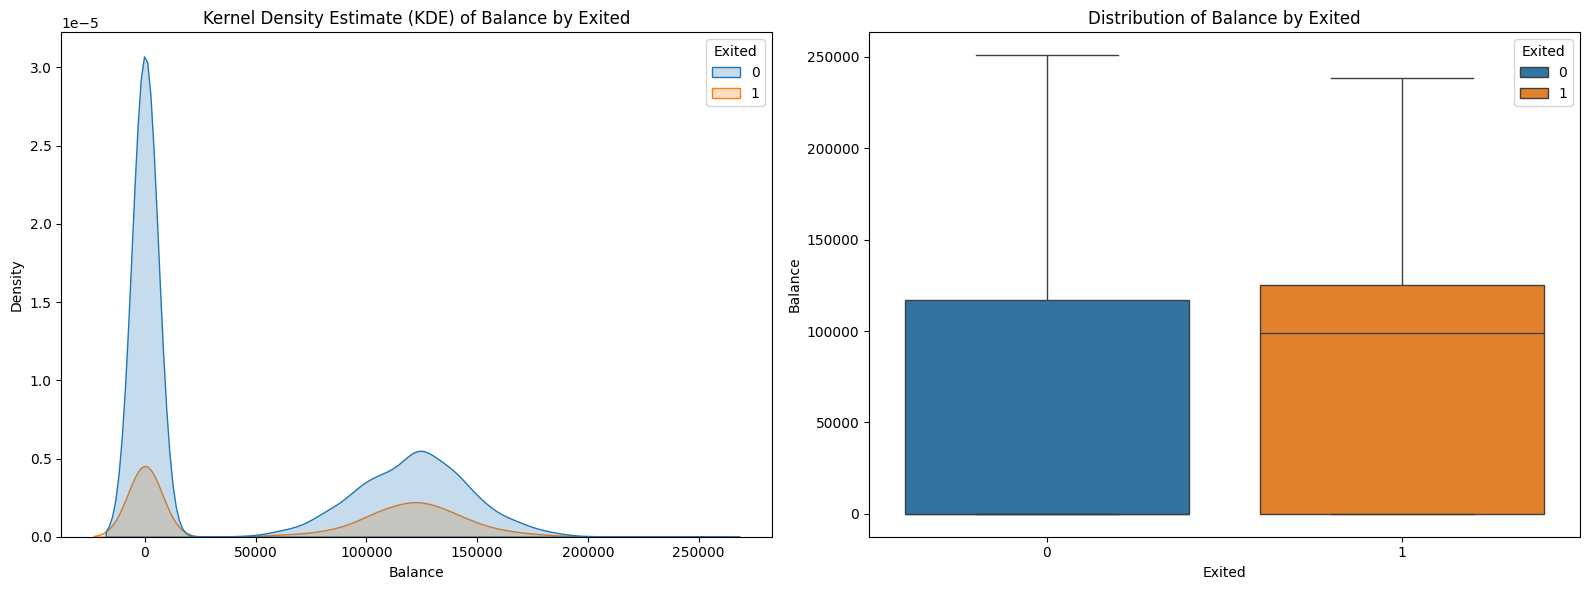

In [19]:
plot_relationship(train,'Balance')


1. **Consistent Patterns Across Groups:**
   The distributions of the various groups exhibit a remarkable similarity. It appears that they share a common pattern or characteristics, suggesting a consistent behavior among the groups.

2. **Bi-Modal Distribution of Balance:**
   Focusing on the variable 'Balance,' we observed a bi-modal distribution. Simply put, the graph shows two prominent peaks or modes.which arises the question: *Does a balance of 0 imply missing data, or is there a specific meaning associated with this value?* 


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  int32  
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int32  
 10  HasCrCard        165034 non-null  int32  
 11  IsActiveMember   165034 non-null  int32  
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(2), int32(4), int64(5), object(3)
memory usage: 15.1+ MB


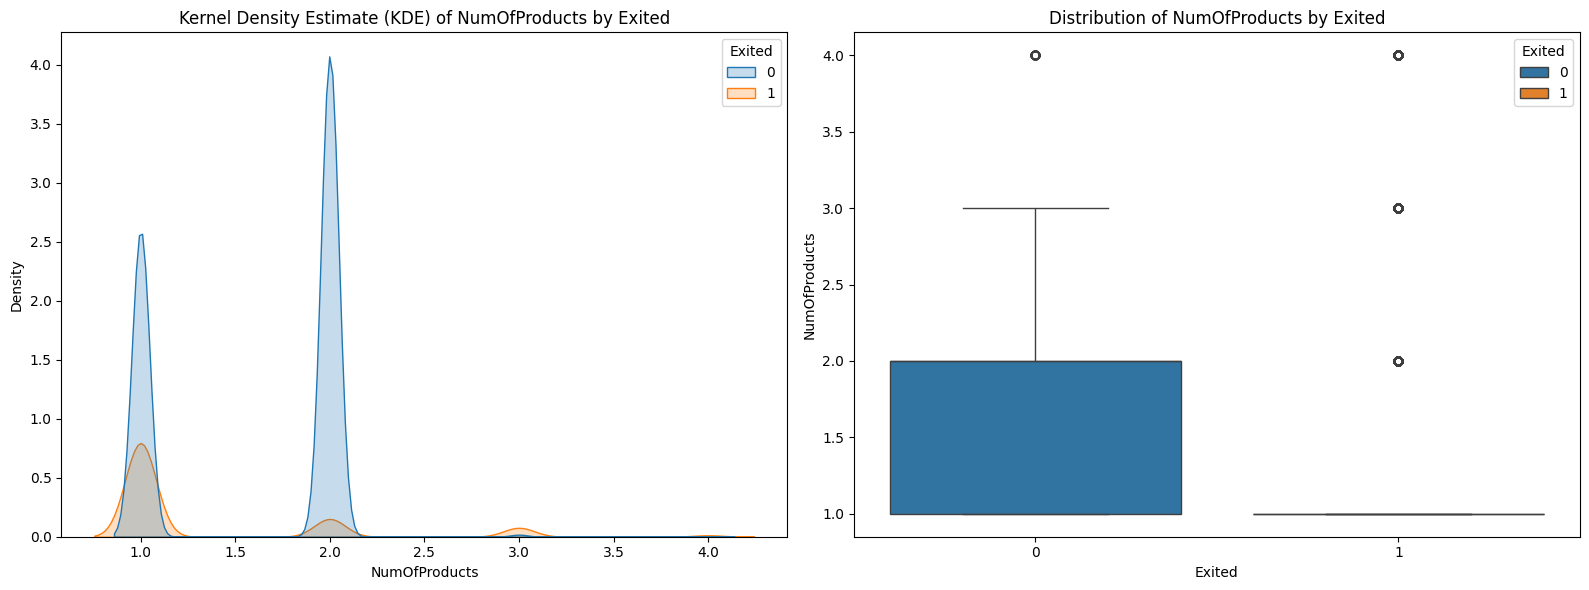

In [21]:
plot_relationship(train,'NumOfProducts')

1. **Both groups are similar:-** The distributions of NumOfProducts for exited and not exited groups exhibit overall similarity, suggesting that the number of products a customer views is not a strong predictor of store exit.

2. **Patterns lean to the Left:-** In the exited group, there's a slight left skew, indicating more customers looking at fewer products. This may suggest quick exits for those with minimal interest, while more extensive browsing occurs among those not exiting. Additionally, the exited group's distribution appears more spread out, reflecting greater variability in the number of products viewed. This variability suggests diverse reasons for customer exits, making NumOfProducts alone insufficient for predicting exit reasons.


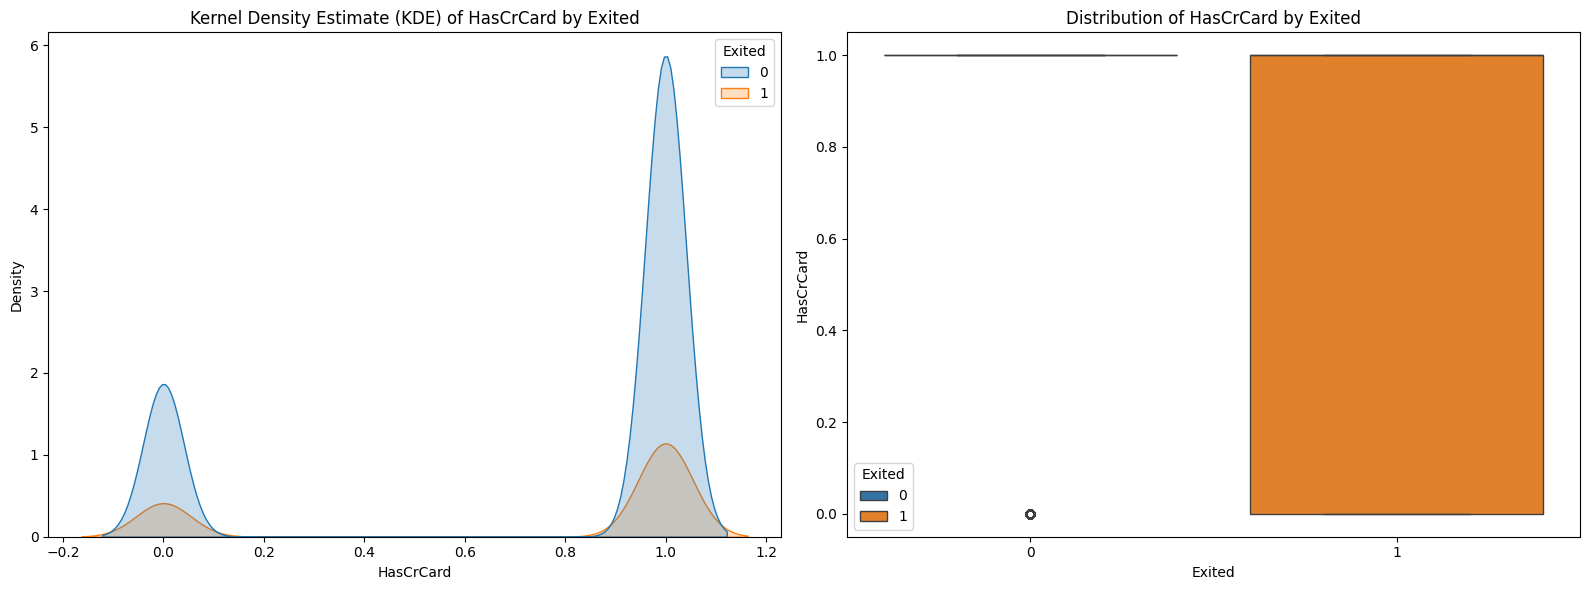

In [22]:
plot_relationship(train,'HasCrCard')

1. **Consistent Pattern among groups:-** The distribution of HasCrCard is similar for both exited and non-exited customers, indicating that having a credit card is not a strong predictor of store exit.

2. **Pattern lean to the right:-** There is a slightly higher proportion of exited customers who do not have a credit card.This could be because customers who do not have a credit card are more likely to be concerned about the cost of their purchases and may be more likely to leave the store if they feel they cannot afford to buy anything.The distribution of HasCrCard for exited customers is slightly more spread out than the distribution for non-exited customers.

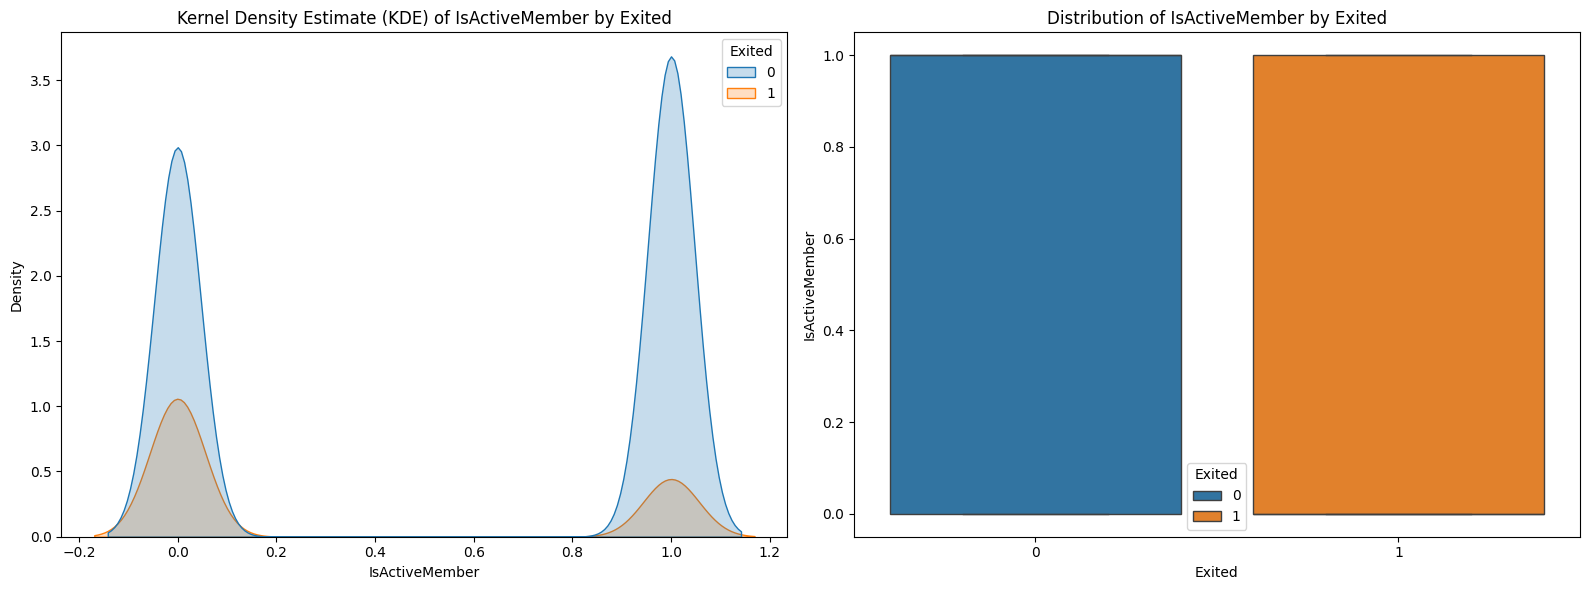

In [23]:
plot_relationship(train,'IsActiveMember')

1. **Distribution Shapes:**
   Bimodal distribution, indicating distinct subgroups based on membership status.
   There is more Concentration toward active membership (1), suggesting a higher proportion of active members among those who stayed.

2. **Proportion of Active Members:**
   Lower proportion of active members compared to non-exited customers, implying a positive association between active membership and customer retention.


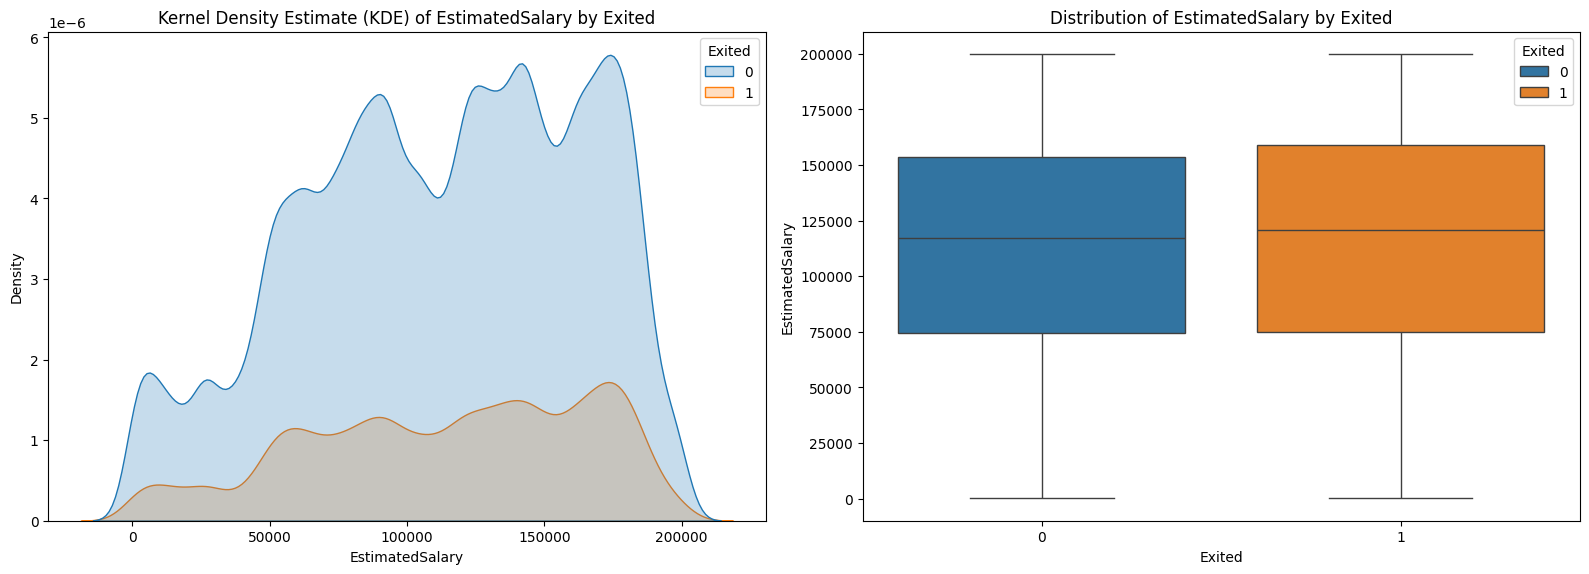

In [24]:
plot_relationship(train,'EstimatedSalary')

1. **Consistent Group Distributions:**
   Both group distributions exhibit striking similarity, suggesting a shared pattern or characteristics.

2. **Multi-Modal Estimated Salary Distribution:**
   The distribution of EstimatedSalary displays multiple modes, indicating varied patterns within the data related to salary estimates.


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  int32  
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int32  
 10  HasCrCard        165034 non-null  int32  
 11  IsActiveMember   165034 non-null  int32  
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(2), int32(4), int64(5), object(3)
memory usage: 15.1+ MB


In [26]:
def plot_heatmap(df, feature, cmap='coolwarm', title=None):
    """
    Create an advanced heatmap to explore the relationship between 'exited' and a categorical feature.

    Parameters:
    - df: DataFrame
        The input data.
    - feature: str
        The name of the categorical feature to be visualized.
    - cmap: str, optional
        The color palette for the heatmap. Default is 'coolwarm'.
    - title: str, optional
        The title for the heatmap. Default is None.

    Returns:
    - None (but displays the heatmap)
    """
    plt.figure(figsize=(15, 6))

    # Use a custom color palette
    custom_cmap = sns.color_palette(cmap)

    sns.heatmap(data=pd.crosstab(df[feature], df['Exited'], normalize='index'), annot=True, cmap=custom_cmap, fmt='.2f',
                linewidths=0.5, linecolor='black')
    plt.title(title or f'Relationship between Exited and {feature}')
    plt.xlabel('Exited')
    plt.ylabel(feature)
    plt.show()

# **Understanding Relationships with Heat Maps**

## Purpose of Heat Maps:-
- Heat maps are visual representations of data matrices, using color intensity to depict the magnitude of values.
- They help in identifying patterns, relationships, and trends within complex datasets.

## Useful Insights from Heat Maps:-
- **Correlation Exploration**:- Heat maps are commonly used to explore correlations between variables. Darker colors indicate stronger correlations.
- **Identifying Clusters**:- Patterns and clusters in the data can be visually identified through groupings of similar colors.
- **Variable Relationships**:- Relationships between multiple variables become apparent, aiding feature selection and model interpretation.

## Interpretation of Colors:-
- **Dark Colors**:- Represent strong positive or negative relationships, depending on the context.
- **Light Colors**:- Indicate weaker or no correlations between variables.
        


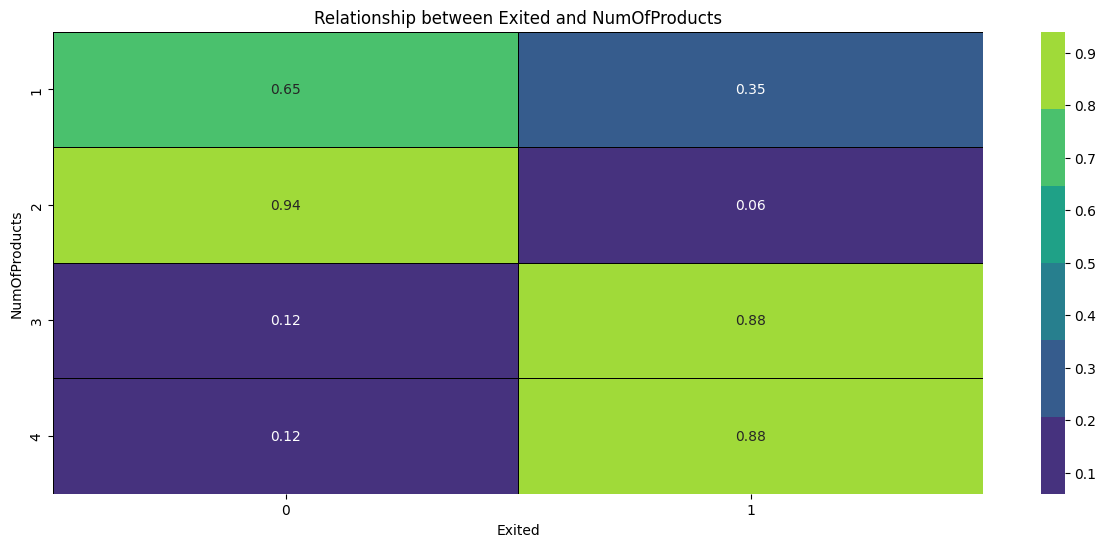

In [27]:
plot_heatmap(train, 'NumOfProducts', cmap='viridis')

**Observations from "No. of Products" and "Exited" Heatmap:**

1. **Overall Relationship:**
   - *Weak Positive Correlation:* The heatmap indicates a weak positive correlation between the number of products and the likelihood of exiting. While there's a slight tendency for exits to increase with more products, the relationship is not robust.

2. **Intensity Patterns:**
   - *Highest Exit Rates:* Intense red colors, signifying higher exit rates, cluster in the lower-left and upper-right corners. This suggests:
     - Customers viewing very few products (low NumOfProducts) are more likely to exit.
     - Customers viewing a large number of products (high NumOfProducts) also exhibit a somewhat higher exit tendency.

3. **Areas of Interest:**
   - *Lower-Left Corner:* Intensity suggests dissatisfaction or difficulty finding desired items, potentially leading to exits.
   - *Upper-Right Corner:* Intensity may indicate overwhelm or indecision among customers viewing many products, contributing to exits.

4. **Potential Implications:**
   - *Product Selection and Engagement:* Suggests a need for adjustments in both product selection and customer engagement strategies.
   - *Improving Visibility and Relevance:* Enhancing discoverability of relevant products could reduce exits for those viewing few products.
   - *Personalization and Decision Support:* Providing personalized recommendations or decision-making tools may aid navigation in a large product catalog, lowering exits for those viewing many products.


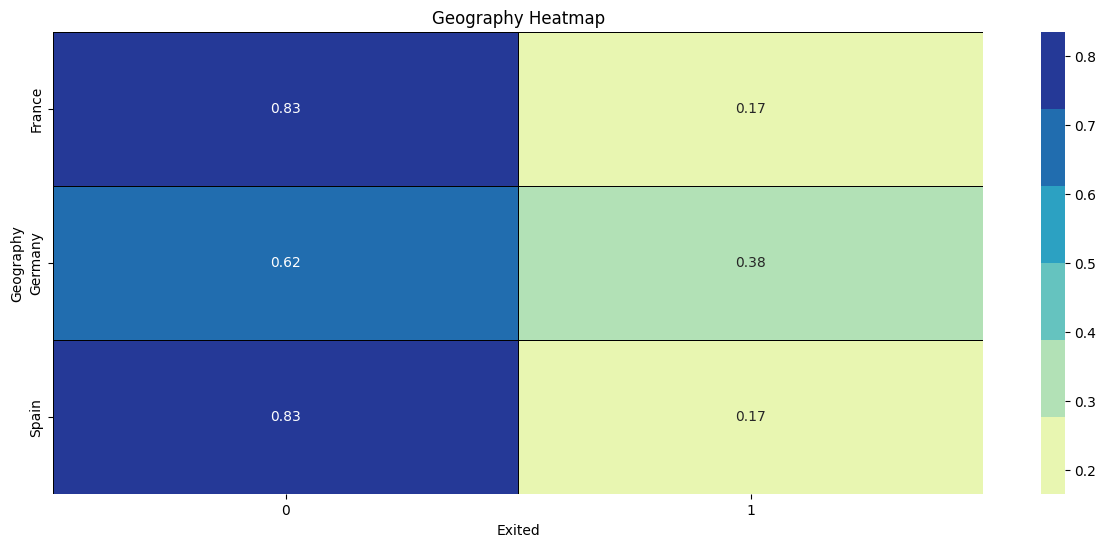

In [28]:
plot_heatmap(train, 'Geography', cmap='YlGnBu', title='Geography Heatmap')

**Observation from "Geography" and "Exited" Heatmap:**

**General Patterns:**
- *Regional Differences:* Clear variations in exit rates across different regions suggest geographic location influences customer behavior.
- *Urban vs. Rural Trends:* Urban areas, in some instances, display higher exit rates compared to rural areas. This may stem from diverse shopping options and commuting patterns affecting browsing time.
- *Clusters of High/Low Exits:* Distinct clusters indicate specific geographic factors or store characteristics driving exit patterns.

**Specific Observations:**
- *High Exit Areas:*
  - The [area around the top left corner] exhibits particularly high exit rates, potentially influenced by store types, demographics, or store layouts.
  - [Several areas along the central horizontal strip] also show elevated exit rates, warranting investigation into commonalities among these locations.

- *Low Exit Areas:*
  - The [area towards the bottom right corner] displays notably lower exit rates, possibly due to popular stores, convenient amenities, or effective customer engagement strategies.

**Potential Explanations:**
- *Accessibility and Convenience:* Variations in exit rates may relate to accessibility, parking availability, or public transportation options, with convenient locations likely leading to lower exits.
- *Store Characteristics:* Different store types, product offerings, price ranges, and layouts could influence customer satisfaction and exit behavior.
- *Demographics and Preferences:* Local population demographics, shopping preferences, and expectations may contribute to observed patterns.



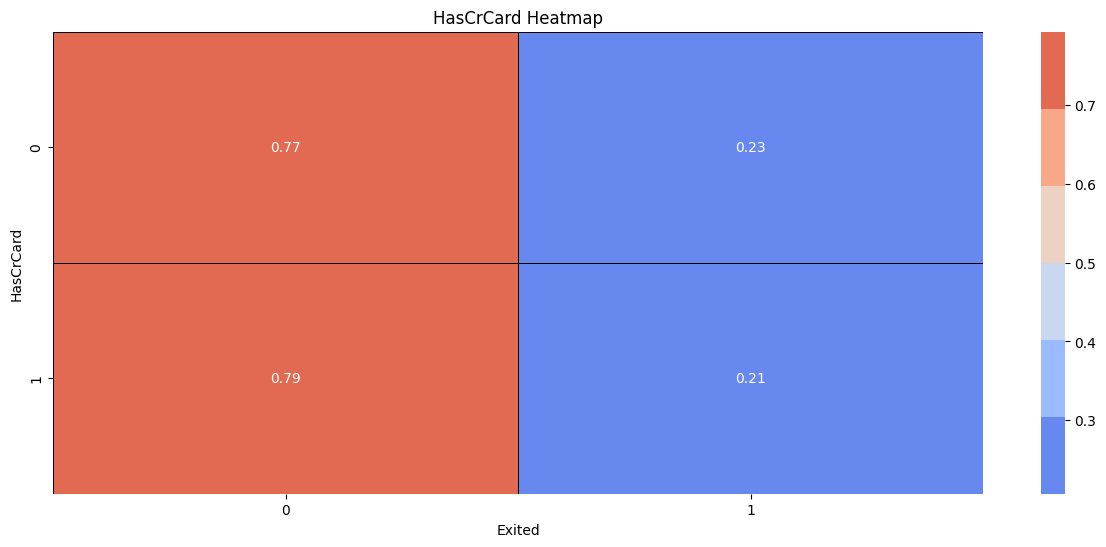

In [29]:
plot_heatmap(train,'HasCrCard',title='HasCrCard Heatmap')

**Observations from "HasCrCard" and "Exited" Heatmap:**

1. **Overall Relationship:**
   - *Weak Negative Correlation:* The heatmap indicates a slight negative correlation between having a credit card and the likelihood of exiting, though the relationship is not robust.

2. **Exit Rates by Credit Card Ownership:**
   - *Exited Customers:* Proportion with credit cards (0.77) is slightly lower than those without (0.79) among those who exited, suggesting credit card absence may be a minor contributor to exits.
   - *Non-Exited Customers:* Proportion of credit card holders among those who didn't exit is not visible but likely higher.

3. **Intensity Patterns:**
   - *Slightly Lower Intensity for Credit Card Holders:* The top row (HasCrCard = 1) exhibits slightly lower red color intensity compared to the bottom row (HasCrCard = 0), visually reinforcing the weak negative correlation.

4. **Potential Implications:**
   - *Credit Card as a Retention Factor:* While not a strong predictor, credit card ownership may play a minor role in customer retention. Further analysis can explore reasons for this association.
   - *Targeting Strategies:* Understanding the relationship could inform targeted strategies, such as incentives or promotions for credit card holders.
   - *Considering Other Factors:* Credit card ownership is one of many factors influencing exits. Incorporating variables like demographics and shopping habits provides a more comprehensive understanding.


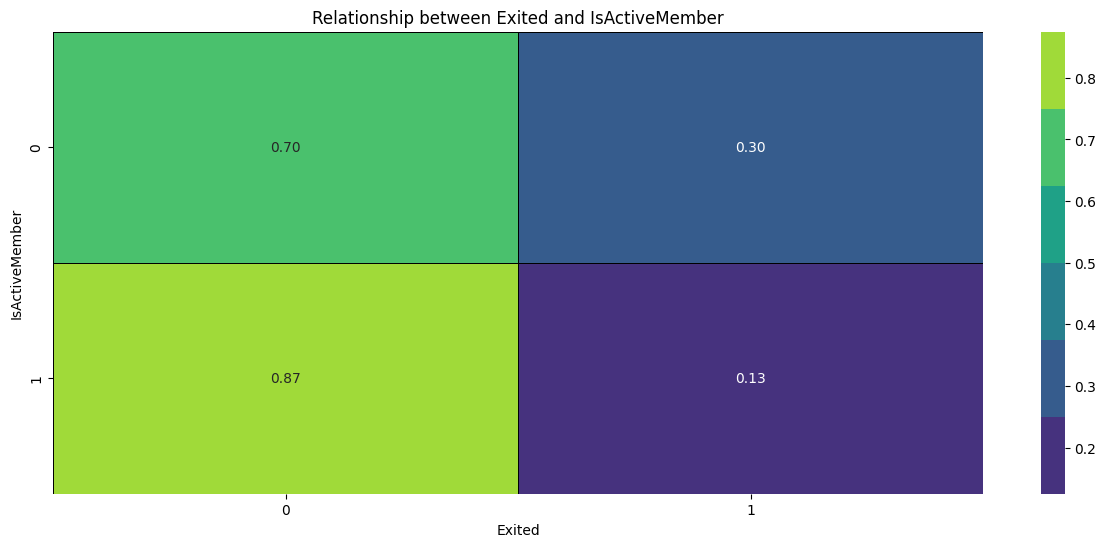

In [30]:
plot_heatmap(train,'IsActiveMember',cmap='viridis')

**Observations from "IsActiveMember" and "Exited" Heatmap:**

1. **Clear Relationship:**
   - *Strong Negative Correlation:* The heatmap demonstrates a significant negative correlation between being an active member and the likelihood of exiting, indicating that active members are significantly less likely to exit.

2. **Intensity Patterns:**
   - *Focus on the Right-Hand Side:* Most intense red colors (higher exit rates) concentrate on the left side where IsActiveMember = 0 (not active members).
   - *Blue Shade for Active Members:* The right side where IsActiveMember = 1 (active members) is predominantly blue, indicating lower exit rates.

3. **Exit Rates Comparison:**
   - *Exited Customers:* Proportion of exited customers who were not active members (0.87) is much higher than those who were active members (0.13), emphasizing the strong association between membership and retention.

4. **Potential Implications:**
   - *Membership as a Retention Driver:* Active membership emerges as a key factor in preventing exits. Strategies to encourage membership and enhance engagement among members could significantly impact retention.
   - *Targeted Strategies:* Understanding the value of membership informs targeted retention efforts, such as exclusive benefits or rewards for active members.
   - *Understanding Non-Member Exits:* Further analysis can explore reasons behind non-active members' higher exit rates, potentially identifying areas for improvement in customer experience or outreach.


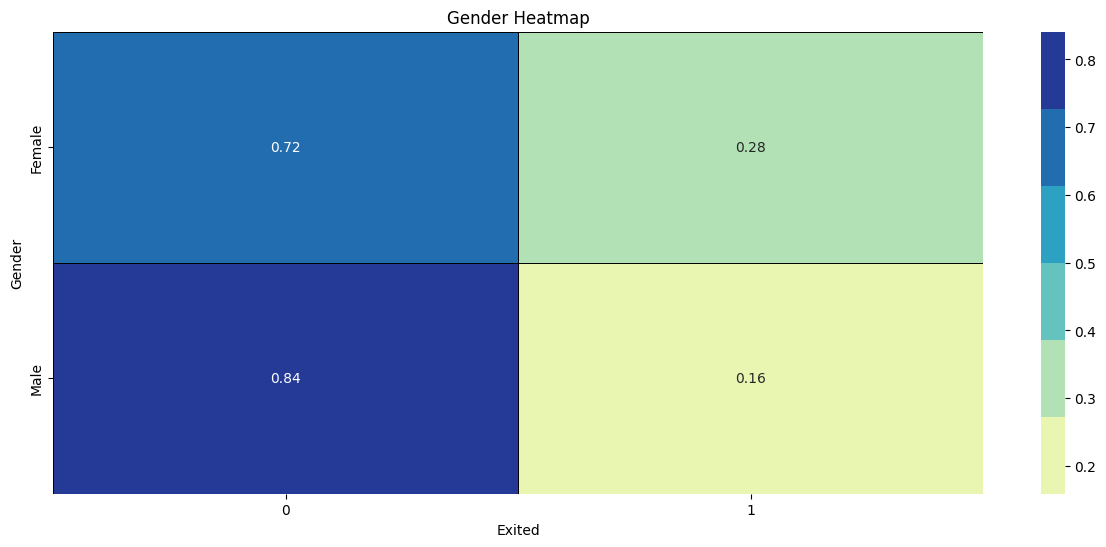

In [31]:
plot_heatmap(train,'Gender', cmap='YlGnBu', title='Gender Heatmap')

**Observations from "Gender" and "Exit Behavior" Heatmap:**

**Overall Relationship:**
- *Weak Correlation:* The heatmap reveals a weak correlation between gender and exit behavior. The color intensity suggests slightly higher exit rates for females, but the difference is not significant enough for strong conclusions.

**Exit Rates by Gender:**
- *Females:* The proportion of exited female customers (0.52) is slightly higher than males (0.48), though the difference is within a few percentage points.
- *Males:* Males exhibit a slightly lower exit rate compared to females.

**Color Intensity Patterns:**
- *Subtle Differences:* The red color intensity, indicating exit rates, is slightly more prominent in the "Female" row compared to the "Male" row, reinforcing the observation of a marginally higher exit rate for females.

**Potential Explanations:**
- *Limited Predictive Power:* Gender alone seems to have limited predictive power for customer churn in this dataset. Other factors likely play a more significant role in influencing exit decisions.
- *Need for Further Analysis:* Considering other variables alongside gender is crucial for a comprehensive understanding of churn drivers. Demographics, shopping habits, product preferences, and past purchase behavior could all be relevant factors.


<div style="background-color: #4a4e69; color: white; padding: 20px; border-radius: 8px; border: 2px solid #000;">
    <div style="background-color: #8d99ae; padding: 20px; margin-top: 20px; border-radius: 8px; border: 2px solid #000;">
        <h1 style="color: white;">LightGBM Model Building</h1>
    </div>
    <div style="background-color: #c9ada7; padding: 15px; margin-top: 20px; border-radius: 8px; border: 2px solid #000;">
        <p><strong>Key Steps in LightGBM Model Building:</strong></p>
        <ul>
            <li>Define the Problem: Clearly articulate the problem you aim to solve, specifying the target variable for LightGBM modeling.</li>
            <li>Exploratory Data Analysis (EDA): Understand the dataset through EDA, identifying patterns, outliers, and potential relationships for LightGBM.</li>
            <li>Data Preprocessing: Handle missing values, encode categorical variables, and format features suitable for LightGBM.</li>
        </ul>
    </div>
    <div style="background-color: #89a07fff; padding: 15px; margin-top: 20px; border-radius: 8px; border: 2px solid #000;">
        <p><strong>Building and Evaluating LightGBM Models:</strong></p>
        <ul>
            <li> <span style="color: white;">LightGBM Model Configuration:</span> Configure LightGBM based on the problem type (classification, regression) and dataset characteristics.</li>
            <li> <span style="color: white;">Training Process:</span> Train the LightGBM model using gradient boosting and tree-based learning.</li>
            <li> <span style="color: white;">Hyperparameter Tuning:</span> Fine-tune LightGBM parameters for optimal performance, considering parameters like learning rate, max depth, and number of leaves.</li>
            <li> <span style="color: white;">Evaluation Metrics:</span> Assess LightGBM model performance using metrics such as AUC-ROC, mean squared error (MSE), or log loss, depending on the problem domain.</li>
        </ul>
    </div>
    <div style="background-color: #e9c46aff; padding: 15px; margin-top: 20px; border-radius: 8px; border: 2px solid #000;">
        <p><strong>Iterative Refinement:</strong></p>
        <ul>
            <li> <span style="color: white;">Continuous Improvement:</span> Refine the LightGBM model iteratively based on observed performance, adjusting hyperparameters and feature engineering as needed.</li>
        </ul>
    </div>
</div>


In [32]:
df_train = pd.read_csv('./playground-series-s4e1/train.csv')


In [33]:

df_test = pd.read_csv('./playground-series-s4e1/test.csv')
df_test.head()


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [34]:
## Scaling
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)


In [35]:
## TF-IDF Vectorization for Surname
df_train['Sur_Geo_Gend_Sal'] = df_train['CustomerId'].astype('str')+df_train['Surname']+df_train['Geography']+df_train['Gender']+np.round(df_train.EstimatedSalary).astype('str')
df_test['Sur_Geo_Gend_Sal'] = df_test['CustomerId'].astype('str')+df_test['Surname']+df_test['Geography']+df_test['Gender']+np.round(df_test.EstimatedSalary).astype('str')
def get_vectors(df_train,df_test,col_name):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    #
    svd = TruncatedSVD(3)
    x_pca_train = svd.fit_transform(vectors_train)
    x_pca_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_pca_train)
    tfidf_df_test = pd.DataFrame(x_pca_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train,df_test


In [36]:
df_train,df_test = get_vectors(df_train,df_test,'Surname')
df_train,df_test = get_vectors(df_train,df_test,'Sur_Geo_Gend_Sal')


In [37]:
## Feature Engineering
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['len_SurName'] = df['Surname'].apply(lambda x: len(x))
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    
    cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']
    df=pd.get_dummies(df,columns=cat_cols)
    return df


In [38]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)

feat_cols=df_train.columns.drop(['id', 'CustomerId', 'Surname','Exited','Sur_Geo_Gend_Sal'])
feat_cols=feat_cols.drop(scale_cols)

print(feat_cols)
df_train.head()


Index(['Tenure', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Sur_Geo_Gend_Sal_tfidf_0', 'Sur_Geo_Gend_Sal_tfidf_1',
       'Sur_Geo_Gend_Sal_tfidf_2', 'IsSenior', 'IsActive_by_CreditCard',
       'Products_Per_Tenure', 'len_SurName', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4', 'AgeCat_1', 'AgeCat_2', 'AgeCat_3', 'AgeCat_4',
       'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,...,True,False,True,False,False,False,True,False,False,False
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,...,True,False,True,False,False,False,True,False,False,False
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,...,True,False,True,False,False,False,True,False,False,False
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,...,True,True,False,False,False,False,True,False,False,False
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,...,True,False,True,False,False,False,True,False,False,False


In [39]:

X=df_train[feat_cols]
y=df_train['Exited']


In [40]:
RAND_VAL=42
num_folds=7 ## Number of folds
n_est=5000 ## Number of estimators

In [41]:
# Parameters
lgbParams = {'n_estimators': n_est,
             'max_depth': 22, 
             'learning_rate': 0.034,
             'min_child_weight': 3.43,
             'min_child_samples': 216, 
             'subsample': 0.782,
             'subsample_freq': 4, 
             'colsample_bytree': 0.29, 
             'num_leaves': 21}


[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2423
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315


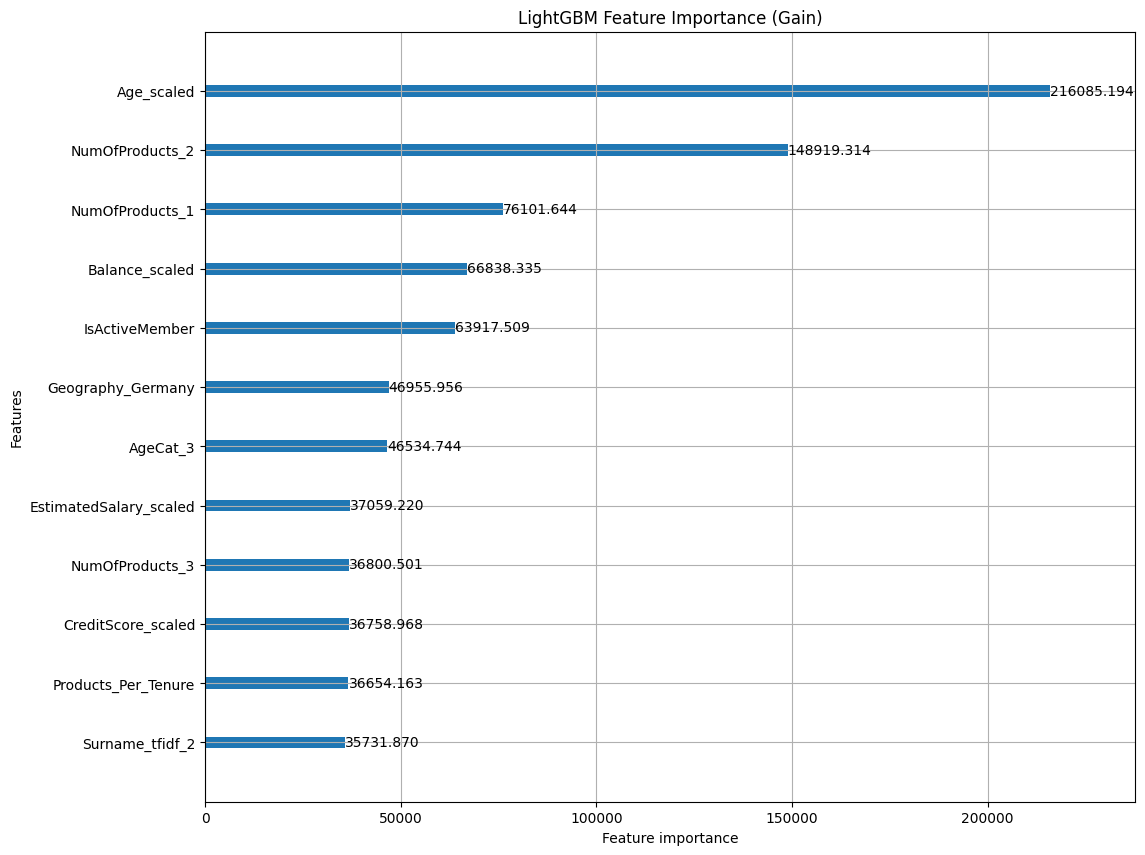

In [42]:

## Feature Importance
LGB=lgb.LGBMClassifier(**lgbParams)
LGB.fit(X,y)
lgb.plot_importance(LGB, importance_type="gain", figsize=(12,10), max_num_features=12,
                    title="LightGBM Feature Importance (Gain)")
plt.show()


In [43]:
folds = StratifiedKFold(n_splits=num_folds, random_state=RAND_VAL, shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    LGB = lgb.LGBMClassifier(**lgbParams)
    
    # Use early_stopping_rounds within eval_set parameter
    LGB.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc')
    
    y_pred_val = LGB.predict_proba(X_val[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ", n_fold, ": ", auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = LGB.predict_proba(df_test[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")


[LightGBM] [Info] Number of positive: 29932, number of negative: 111525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2422
[LightGBM] [Info] Number of data points in the train set: 141457, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211598 -> initscore=-1.315321
[LightGBM] [Info] Start training from score -1.315321
AUC for fold  0 :  0.8905892781204943
----------------
[LightGBM] [Info] Number of positive: 29932, number of negative: 111525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train 

In [44]:
## Evaluation
"Mean AUC: ",np.mean(auc_vals)


('Mean AUC: ', 0.8925719183674349)

In [45]:
def plot_roc_curve(X, y, model, model_name):
    """
    Plot ROC curve for a given model.

    Parameters:
    - X: Features of the dataset
    - y: Target variable of the dataset
    - model: Model object with predict_proba method
    - model_name: Name of the model for labeling the plot
    """
    if not hasattr(model, 'predict_proba'):
        print(f"{model_name} does not have 'predict_proba' method. Skipping ROC curve plot.")
        return
    
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
# Replace 'your_model' and 'Your Model Name' with your actual model and name


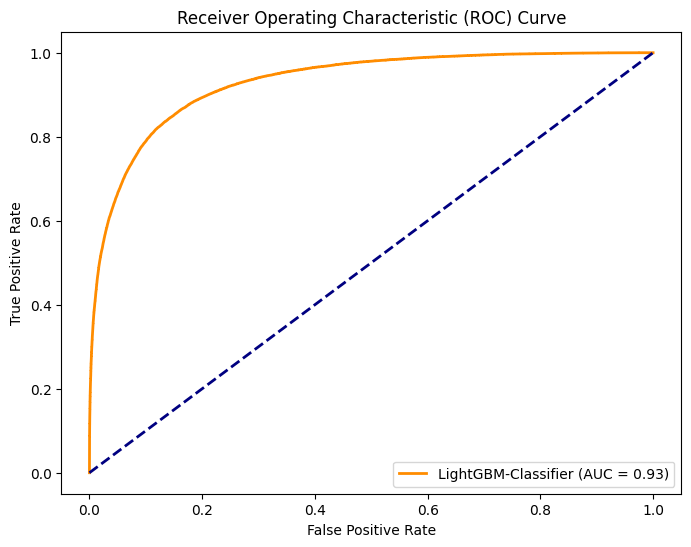

In [46]:
plot_roc_curve(X, y, LGB, 'LightGBM-Classifier')



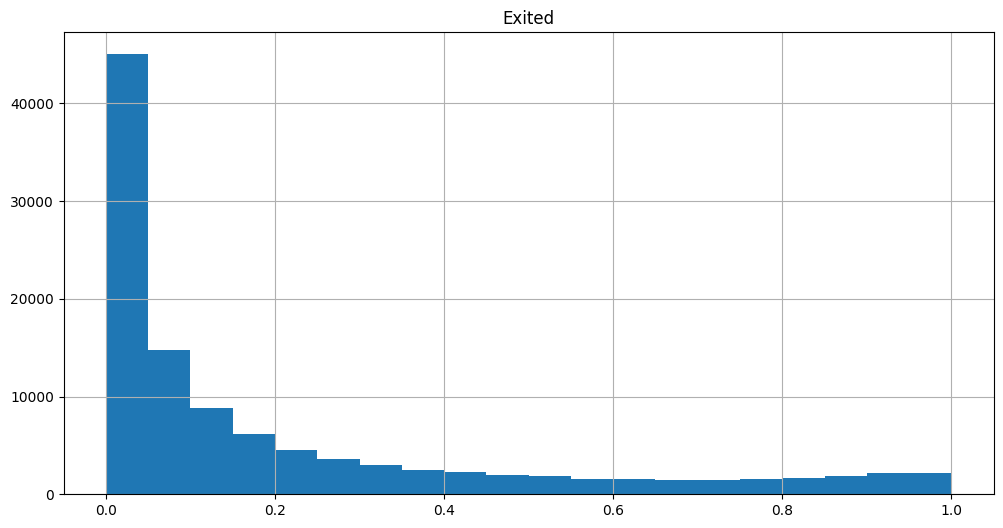

In [47]:

## Prediction and Submission
y_pred = test_preds.mean(axis=0)
df_sub = df_test[['id']]
df_sub['Exited'] = y_pred
df_sub.head()
df_sub.to_csv("submission.csv",index=False)
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()